# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.46KFile/s]


Extracting celeba...


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

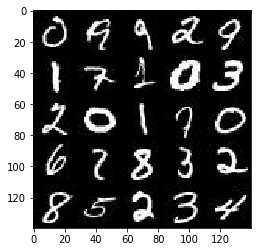

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

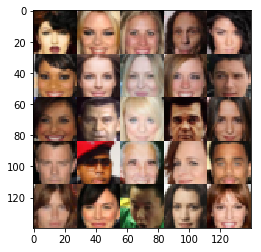

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28 * 28 * 3
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        # 14 * 14 * 64
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 * 7 * 128
        
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4 * 4 * 256
        
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [37]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        layer1 = tf.layers.dense(z, 7 * 7 * 512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(layer1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7 * 7 * 512
        
        layer2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14 * 14 * 256
        
        layer3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 28 * 28 * 128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same')
        # 28 * 28 * out_channel_dim
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, learning_rate_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.3663... Generator Loss: 5.1718...
Epoch 1/2... Discriminator Loss: 0.3789... Generator Loss: 3.7738...
Epoch 1/2... Discriminator Loss: 0.3579... Generator Loss: 4.7467...
Epoch 1/2... Discriminator Loss: 0.3861... Generator Loss: 6.4500...
Epoch 1/2... Discriminator Loss: 0.4180... Generator Loss: 2.8436...
Epoch 1/2... Discriminator Loss: 0.4012... Generator Loss: 7.7487...
Epoch 1/2... Discriminator Loss: 0.3745... Generator Loss: 4.1047...
Epoch 1/2... Discriminator Loss: 0.4143... Generator Loss: 2.8940...
Epoch 1/2... Discriminator Loss: 0.3966... Generator Loss: 6.7624...
Epoch 1/2... Discriminator Loss: 5.0687... Generator Loss: 0.0273...


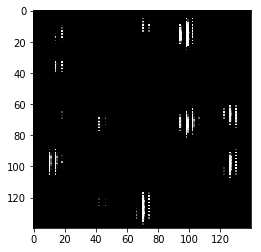

Epoch 1/2... Discriminator Loss: 1.1074... Generator Loss: 1.0369...
Epoch 1/2... Discriminator Loss: 0.5337... Generator Loss: 2.3965...
Epoch 1/2... Discriminator Loss: 2.3566... Generator Loss: 0.4529...
Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 2.4731...
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 1.6406...
Epoch 1/2... Discriminator Loss: 0.8114... Generator Loss: 1.6149...
Epoch 1/2... Discriminator Loss: 1.5943... Generator Loss: 0.5440...
Epoch 1/2... Discriminator Loss: 1.6199... Generator Loss: 0.4642...
Epoch 1/2... Discriminator Loss: 1.8305... Generator Loss: 0.3409...
Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.6691...


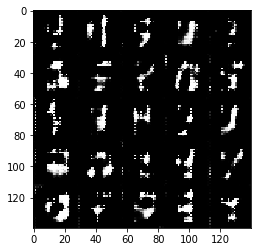

Epoch 1/2... Discriminator Loss: 2.2688... Generator Loss: 1.6807...
Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 0.9490...
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 1.3413...
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.8326...
Epoch 1/2... Discriminator Loss: 2.1393... Generator Loss: 3.0277...
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 2.0643...
Epoch 1/2... Discriminator Loss: 1.4223... Generator Loss: 1.4055...
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 1.1399...
Epoch 1/2... Discriminator Loss: 1.4946... Generator Loss: 0.7236...
Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.7219...


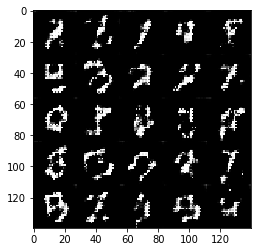

Epoch 1/2... Discriminator Loss: 1.6442... Generator Loss: 1.0780...
Epoch 1/2... Discriminator Loss: 1.7777... Generator Loss: 0.4948...
Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 1.0679...
Epoch 1/2... Discriminator Loss: 1.5889... Generator Loss: 0.5295...
Epoch 1/2... Discriminator Loss: 1.2491... Generator Loss: 0.7365...
Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 1.4291...
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 1.5135...
Epoch 1/2... Discriminator Loss: 1.8601... Generator Loss: 1.6465...
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.9336...
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.6676...


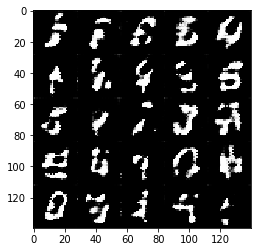

Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 1.2658...
Epoch 1/2... Discriminator Loss: 1.8215... Generator Loss: 0.3048...
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 1.0809...
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.5942...
Epoch 1/2... Discriminator Loss: 1.5238... Generator Loss: 1.3001...
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.7477...
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.6474...
Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.6914...
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 1.0991...
Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 0.9990...


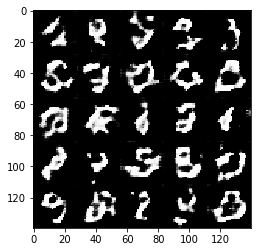

Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 1.2147...
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 1.2951...
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 1.2836...
Epoch 1/2... Discriminator Loss: 1.5409... Generator Loss: 1.7009...
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 1.0051...
Epoch 1/2... Discriminator Loss: 1.4202... Generator Loss: 0.6058...
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 1.2646...
Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 0.8735...
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.5870...
Epoch 1/2... Discriminator Loss: 1.2745... Generator Loss: 0.8041...


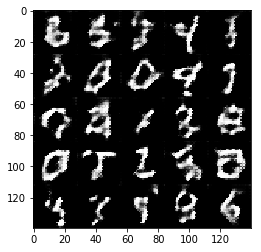

Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 0.7525...
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 1.2749...
Epoch 1/2... Discriminator Loss: 1.4533... Generator Loss: 1.0921...
Epoch 1/2... Discriminator Loss: 1.4540... Generator Loss: 0.6022...
Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 0.8533...
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 1.4036...
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 1.2970...
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 0.9393...
Epoch 1/2... Discriminator Loss: 1.2637... Generator Loss: 1.1322...
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 1.0910...


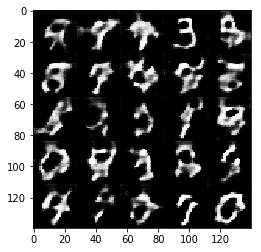

Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 0.7973...
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.6566...
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 0.8791...
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 1.1366...
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.6603...
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 0.9371...
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.9701...
Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 0.8306...
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 1.0101...
Epoch 1/2... Discriminator Loss: 1.2631... Generator Loss: 1.2312...


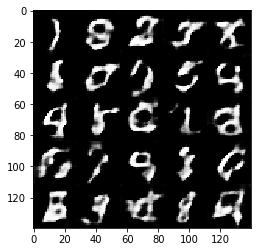

Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.8314...
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 1.2076...
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 1.1844...
Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 0.6996...
Epoch 1/2... Discriminator Loss: 1.3325... Generator Loss: 0.7637...
Epoch 1/2... Discriminator Loss: 1.4533... Generator Loss: 0.5680...
Epoch 1/2... Discriminator Loss: 1.4420... Generator Loss: 0.5546...
Epoch 1/2... Discriminator Loss: 1.3166... Generator Loss: 1.1594...
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.8057...
Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 0.7074...


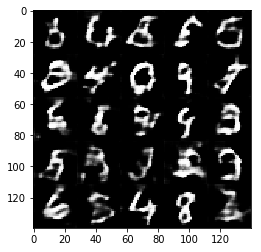

Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.9255...
Epoch 1/2... Discriminator Loss: 1.2599... Generator Loss: 0.9875...
Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 1.4727...
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 1.1531...
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.7853...
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 1.1995...
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.8007...
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 1.0804...
Epoch 2/2... Discriminator Loss: 1.2710... Generator Loss: 1.1005...
Epoch 2/2... Discriminator Loss: 1.3595... Generator Loss: 0.8916...


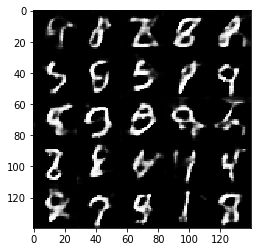

Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 0.6010...
Epoch 2/2... Discriminator Loss: 1.3000... Generator Loss: 1.1146...
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 1.2850...
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.8692...
Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 0.9035...
Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 1.1729...
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.8233...
Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 1.0972...
Epoch 2/2... Discriminator Loss: 1.3067... Generator Loss: 1.0699...
Epoch 2/2... Discriminator Loss: 1.3420... Generator Loss: 0.7044...


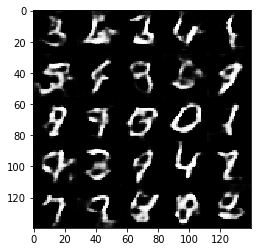

Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.8791...
Epoch 2/2... Discriminator Loss: 1.2589... Generator Loss: 1.1865...
Epoch 2/2... Discriminator Loss: 1.2945... Generator Loss: 0.8231...
Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 0.8711...
Epoch 2/2... Discriminator Loss: 1.3309... Generator Loss: 0.7073...
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.9690...
Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 1.5107...
Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 0.7831...
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.6687...
Epoch 2/2... Discriminator Loss: 1.3470... Generator Loss: 0.9969...


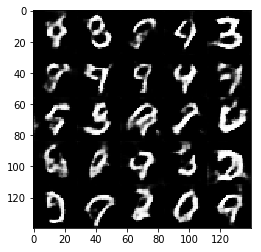

Epoch 2/2... Discriminator Loss: 1.3976... Generator Loss: 1.4560...
Epoch 2/2... Discriminator Loss: 1.2708... Generator Loss: 0.9523...
Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.9295...
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 0.5795...
Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 1.0537...
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.8577...
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.8649...
Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.7259...
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 0.9533...
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.8005...


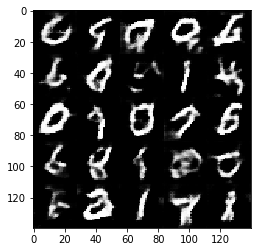

Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 1.0281...
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.9454...
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.7645...
Epoch 2/2... Discriminator Loss: 1.4153... Generator Loss: 0.7238...
Epoch 2/2... Discriminator Loss: 1.2997... Generator Loss: 0.9223...
Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 1.0680...
Epoch 2/2... Discriminator Loss: 1.3352... Generator Loss: 1.0504...
Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 1.2317...
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 1.1621...
Epoch 2/2... Discriminator Loss: 1.3084... Generator Loss: 1.1600...


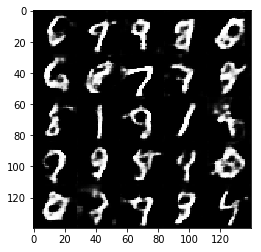

Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.9163...
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 1.0308...
Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 1.2094...
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.6488...
Epoch 2/2... Discriminator Loss: 1.3066... Generator Loss: 0.8816...
Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 1.1632...
Epoch 2/2... Discriminator Loss: 1.4533... Generator Loss: 1.3790...
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 1.3318...
Epoch 2/2... Discriminator Loss: 1.3444... Generator Loss: 0.9156...
Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.6489...


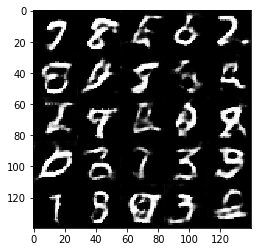

Epoch 2/2... Discriminator Loss: 1.3216... Generator Loss: 0.7675...
Epoch 2/2... Discriminator Loss: 1.2905... Generator Loss: 0.9562...
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.6437...
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 1.1587...
Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.6280...
Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.7981...
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.8313...
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.9993...
Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 0.9419...
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 1.0557...


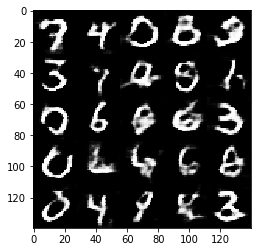

Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 0.8785...
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.6259...
Epoch 2/2... Discriminator Loss: 1.2736... Generator Loss: 0.9310...
Epoch 2/2... Discriminator Loss: 1.3068... Generator Loss: 0.7685...
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 1.0774...
Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.9946...
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.7243...
Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 0.6617...
Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 1.1116...
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 0.6743...


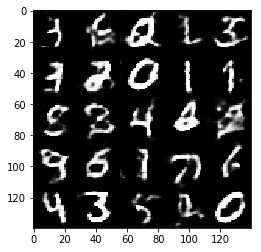

Epoch 2/2... Discriminator Loss: 1.2863... Generator Loss: 0.7786...
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.6677...
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 0.6402...
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 1.1792...
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 0.9804...
Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 0.7238...
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 0.9763...
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 0.9961...
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.8061...
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.5905...


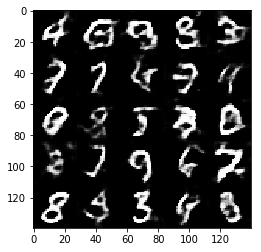

Epoch 2/2... Discriminator Loss: 1.2762... Generator Loss: 0.8414...
Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 1.0193...
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.8505...
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 1.1188...
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.8798...
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 1.0422...
Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 0.5436...


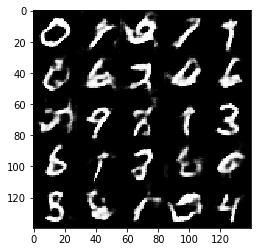

In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 5.0031...
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 5.5960...
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 5.4168...
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 4.2241...
Epoch 1/1... Discriminator Loss: 0.3412... Generator Loss: 5.6695...
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 4.3374...
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 9.2059...
Epoch 1/1... Discriminator Loss: 0.3423... Generator Loss: 8.1429...
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 1.1806...
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 2.8882...


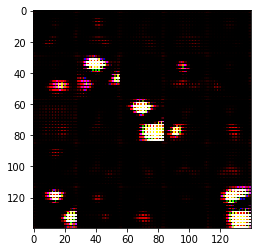

Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 1.0347...
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.8852...
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.9709...
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7411...
Epoch 1/1... Discriminator Loss: 1.7870... Generator Loss: 3.2430...
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 1.7309...
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.4636...
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8486...
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.0313...
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.8597...


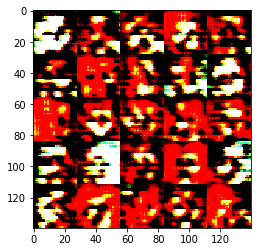

Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.2079...
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 1.8675...
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.1906...
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.5985...
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 2.4428...
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 3.3001...
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 2.2695...
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.4783...
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 1.9785...
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 1.7656...


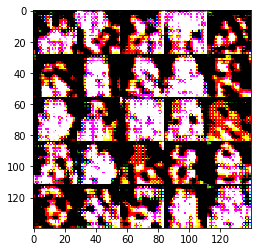

Epoch 1/1... Discriminator Loss: 1.6747... Generator Loss: 0.4976...
Epoch 1/1... Discriminator Loss: 2.4105... Generator Loss: 0.2096...
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 3.0557...
Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 1.7920...
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 2.5443...
Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 1.8483...
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 2.7232...
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 1.9785...
Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 3.9149...
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.4686...


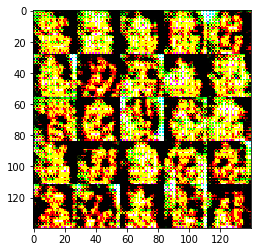

Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 1.4838...
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 2.1168...
Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 1.1550...
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.4287...
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 2.1530...
Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 2.7978...
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 4.4969...
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 2.5024...
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.8443...
Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 2.7147...


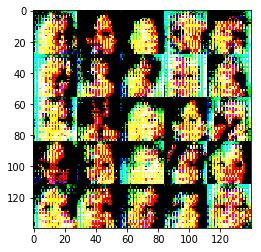

Epoch 1/1... Discriminator Loss: 1.9436... Generator Loss: 7.3036...
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 2.6413...
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.6627...
Epoch 1/1... Discriminator Loss: 0.4051... Generator Loss: 3.5019...
Epoch 1/1... Discriminator Loss: 0.3958... Generator Loss: 3.9041...
Epoch 1/1... Discriminator Loss: 0.4351... Generator Loss: 2.5845...
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 3.4742...
Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 5.8927...
Epoch 1/1... Discriminator Loss: 0.3771... Generator Loss: 3.5704...
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 5.6888...


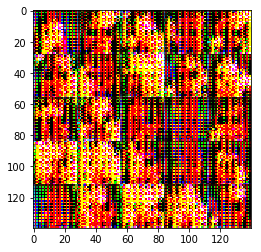

Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 8.0235...
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 3.4766...
Epoch 1/1... Discriminator Loss: 0.3681... Generator Loss: 3.9642...
Epoch 1/1... Discriminator Loss: 0.3481... Generator Loss: 5.0495...
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 2.3081...
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 2.1769...
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.8871...
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.3002...
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 2.5675...
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.6419...


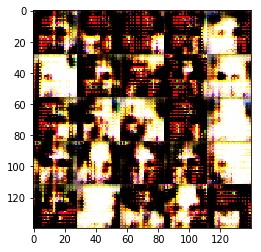

Epoch 1/1... Discriminator Loss: 0.4526... Generator Loss: 2.7465...
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 3.0208...
Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 2.5442...
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 5.0946...
Epoch 1/1... Discriminator Loss: 0.8122... Generator Loss: 1.9498...
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 2.2529...
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 3.0337...
Epoch 1/1... Discriminator Loss: 0.4516... Generator Loss: 2.8381...
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 2.6669...
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.9987...


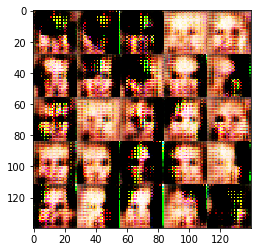

Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.3546...
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 4.2970...
Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 4.3281...
Epoch 1/1... Discriminator Loss: 0.7353... Generator Loss: 2.2321...
Epoch 1/1... Discriminator Loss: 2.5408... Generator Loss: 5.3227...
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 4.5363...
Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 2.3012...
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.5756...
Epoch 1/1... Discriminator Loss: 1.9967... Generator Loss: 0.2665...
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.7422...


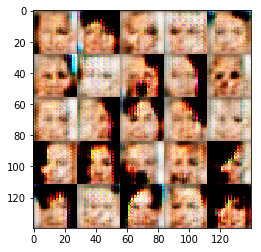

Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 2.1518...
Epoch 1/1... Discriminator Loss: 2.0074... Generator Loss: 0.2474...
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.7420...
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 2.7825...
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.2178...
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.9024...
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.6983...
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 2.1027...
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.6746...
Epoch 1/1... Discriminator Loss: 2.6120... Generator Loss: 4.9722...


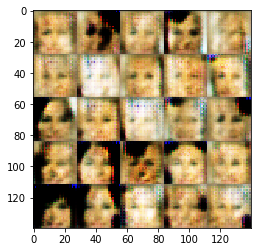

Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 0.9622...
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.5194...
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.9486...
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.4673...
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.5931...
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.7339...
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.4928...
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 1.1779...
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.0241...
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 2.1368...


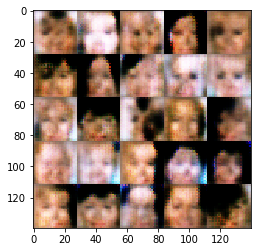

Epoch 1/1... Discriminator Loss: 2.0995... Generator Loss: 3.9123...
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.8926...
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 1.1895...
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8008...
Epoch 1/1... Discriminator Loss: 1.7348... Generator Loss: 0.3807...
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.5162...
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 1.2348...
Epoch 1/1... Discriminator Loss: 1.6829... Generator Loss: 0.9863...
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.7789...
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.8296...


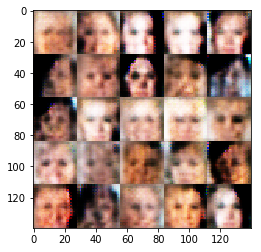

Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.1835...
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 1.0859...
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.8087...
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.0340...
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.2243...
Epoch 1/1... Discriminator Loss: 1.8753... Generator Loss: 0.3289...
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.7218...
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 1.1407...
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 1.1133...
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.9011...


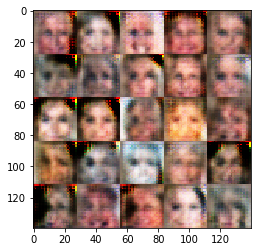

Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.9091...
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.8891...
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.2145...
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.9141...
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.5999...
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 1.2753...
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 1.0929...
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7138...
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.9353...
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.6488...


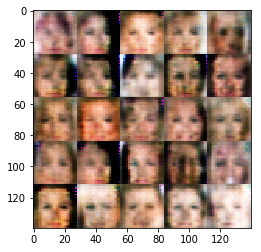

Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 0.4791...
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.4671...
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 1.1810...
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.9030...
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.8618...
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8135...
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6940...
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.9212...
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5856...
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.1474...


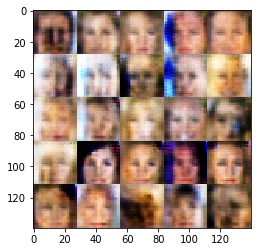

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 1.2754...
Epoch 1/1... Discriminator Loss: 1.8321... Generator Loss: 0.3508...
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9244...
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.8142...
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8158...
Epoch 1/1... Discriminator Loss: 1.7305... Generator Loss: 1.0572...
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.7472...
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.8636...
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8149...
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 1.2721...


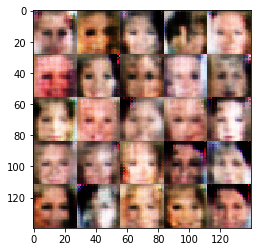

Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.9985...
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 1.2068...
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.8938...
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.9075...
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6450...
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.7557...
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.8602...
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8252...
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8106...
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.9947...


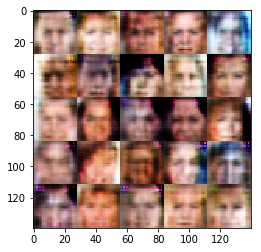

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 1.0520...
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.0125...
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 2.0260...
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 1.1063...
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 0.6155...
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.7637...
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7054...
Epoch 1/1... Discriminator Loss: 1.6971... Generator Loss: 0.3960...
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6258...
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.8248...


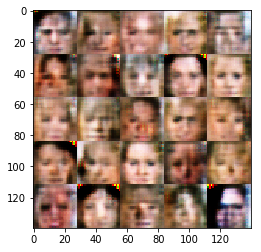

Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8274...
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6874...
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7077...
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.6270...
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.7086...
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.9872...
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.9277...
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.9164...
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7956...
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 1.5248...


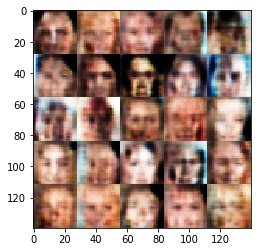

Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 1.1436...
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.8368...
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 1.4034...
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6583...
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 1.2076...
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 1.0710...
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 1.0162...
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8098...
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.9304...
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 1.2736...


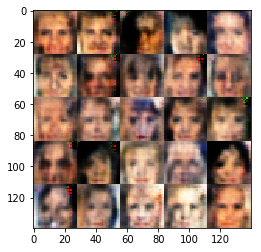

Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.8144...
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8833...
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 1.2939...
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.4994...
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 1.1396...
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.9412...
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.9973...
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.8360...
Epoch 1/1... Discriminator Loss: 1.6238... Generator Loss: 0.9825...
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.7633...


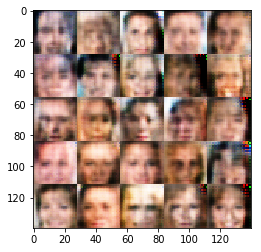

Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.9451...
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.5917...
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 1.0664...
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.9229...
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.9296...
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7444...
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 1.0070...
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 1.2172...
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 1.1556...
Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 1.3727...


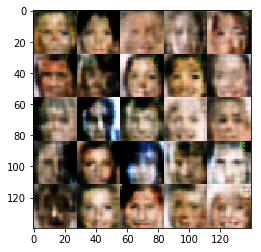

Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.9080...
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8470...
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7331...
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.6473...
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.6866...
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7843...
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.8895...
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.9782...
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.9138...
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 1.1071...


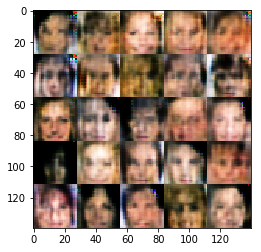

Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.9446...
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 1.3207...


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。